In [3]:
import numpy as np
from scipy.stats import beta as bt
import matplotlib.pyplot as plt
from numpy import genfromtxt
plt.style.use('ggplot')

In [ ]:
# epsilon-greedy


In [ ]:
# Thompson Sampling
def Thompson(t_len, k_len, arms, priors, seed=5):
    np.random.seed(seed)
    culm_chosen = []
    alpha = [priors[0] for k in range(k_len)]
    beta = [priors[1] for k in range(k_len)]
    for t in range(t_len):
        samples = [np.random.beta(alpha[k],beta[k]) for k in range(k_len)] # Collect samples
        best = np.argmax(samples) # Choose best
        r = np.random.random()<arms[best] # observe r_t (reward and for some reason 'True' counts as the value 1)
        # Update the state of the winning arm 
        alpha[best] += r
        beta[best] += 1-r
        # Append best
        culm_chosen.append(best)
    return alpha,beta,culm_chosen

# Plot posterior arm choices
def plot_res(a,b, t_len):
    x=np.linspace(0,1,1000)
    for  i in range(2):
        y = bt(a[i], b[i])
        plt.plot(x,y.pdf(x),  label=f'Posterior: Arm {i+1}, prob {arms[i]}')
    plt.title(f'T={t_len} rounds')
    plt.xlabel('Prob.')
    plt.legend()
    plt.show()

In [ ]:
# UCB-Bayes


In [ ]:
# regret
def get_regret(arms, culm_chosen, t_len):
    # Keep empty list to update
    regret=[]
    # Range over length of T
    for T in range(1,t_len+1):
        # Iterate over arms (i know the best arm goes to 0 but i thought id generalise it anyway)
        armval = []
        for idx, arm in enumerate(arms):
            # use the regret rule from notes, take mean of the indicator choices up to the round T
            armval.append((arms[np.argmax(arms)]-arm)*(np.mean([culm_chosen[i]==idx for i in range(0,T)])))
        # Add arm 1 and arm 2 values (i know this is pointless since the best arm is 0 so only counts for non optimal arm)
        regret.append(armval[0]+armval[1])
    return regret

# To plot regret
def plot_reg(regret,ucb,t_len):
    plt.plot(np.cumsum(regret), label='Thompson regret')
    plt.plot(ucb, label='UCB1 regret')
    plt.plot(np.linspace(1,t_len), np.log(np.linspace(1,t_len)), label='log', color='orange')
    plt.legend()
    plt.title(f'Regret T={t_len}')
    plt.show()    


In [ ]:
# results

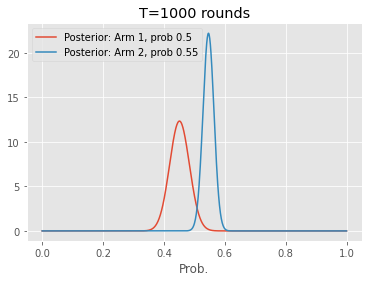

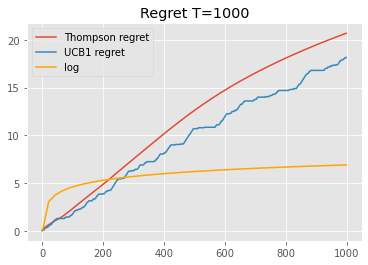

In [5]:
# Flat 1,1 priors, 1000 rounds
t_len=1000
arms = [0.5, 0.55]
prior=[1,1]
alpha,beta,c=Thompson(t_len,2,arms, prior)
regret=get_regret(arms, c, t_len)
plot_res(alpha,beta, t_len)
ucb_reg = genfromtxt('ucb1T1000.csv', delimiter=',').T[1][1:]
plot_reg(regret,ucb_reg, t_len)

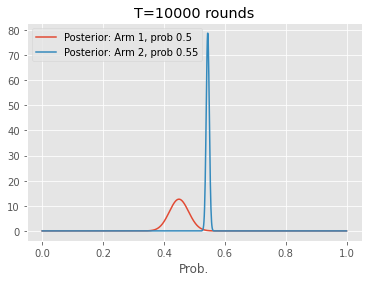

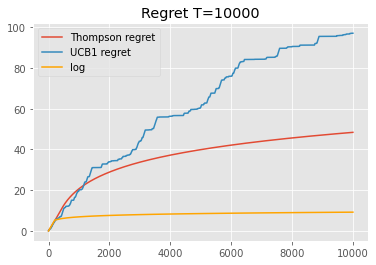

In [6]:
# Flat 1,1 priors, 10000 rounds
t_len=10000
arms = [0.5, 0.55]
prior=[1,1]
alpha,beta,c=Thompson(t_len,2,arms, prior)
regret=get_regret(arms, c, t_len)
ucb_reg = genfromtxt('ucb1T10000.csv', delimiter=',').T[1][1:]
plot_res(alpha,beta, t_len)

plot_reg(regret, ucb_reg,t_len)